<a href="https://colab.research.google.com/github/Jay-hv7/DL-Practice/blob/main/pytorch_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jayhv7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.46GB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device='cuda' if torch.cuda.is_available() else 'cpu'
print("device =",device)

device = cuda


In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")

In [5]:
data_df.shape

(18185, 12)

In [6]:
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


### Minimal Preprocessing

In [7]:
data_df.dropna(inplace=True)

In [8]:
data_df.drop(['id'],axis=1,inplace=True) # column

In [9]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [10]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [11]:
original_df = data_df.copy()

In [12]:
for column in data_df.columns:
  data_df[column]=data_df[column]/data_df[column].abs().max()

In [14]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [16]:
X = np.array(data_df.iloc[:,:-1])
y  = np.array(data_df.iloc[:,-1])

In [17]:
print(X.shape)
print(y.shape)

(18185, 10)
(18185,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [40]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5, random_state=42)

In [41]:
print("X train  X_test   X validation",X_train.shape,X_test.shape,X_val.shape)
print("y train  y_test  y validation",y_train.shape,y_test.shape,y_val.shape)


X train  X_test   X validation (12729, 10) (1336, 10) (1337, 10)
y train  y_test  y validation (12729,) (1336,) (1337,)


### PyTorch

In [42]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X=torch.tensor(X, dtype=torch.float32).to(device)
    self.y = torch.tensor(y, dtype=torch.float32).to(device)
  def __len__(self):
      return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [43]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val,y_val)
testing_data = dataset(X_test, y_test)

In [44]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)

In [45]:
for X,y in train_dataloader:
  print(X.shape)
  print(X)
  print(y.shape)
  print(y)
  break

torch.Size([8, 10])
tensor([[0.5843, 0.8502, 0.6031, 0.9801, 0.5568, 0.7644, 0.7427, 0.6790, 0.6951,
         0.7998],
        [0.6632, 0.7806, 0.7349, 0.9367, 0.6244, 0.8144, 0.7400, 0.6500, 0.8608,
         0.6026],
        [0.8497, 0.8739, 0.8484, 0.9302, 0.8042, 0.9218, 0.8975, 0.7401, 0.8508,
         0.5844],
        [0.8006, 0.8535, 0.8168, 0.9333, 0.7570, 0.8948, 0.7628, 0.7329, 0.8173,
         0.5929],
        [0.7354, 0.6845, 0.9656, 0.7985, 0.7051, 0.8575, 0.8472, 0.6753, 0.8844,
         0.4022],
        [0.5505, 0.8024, 0.5980, 0.9743, 0.5309, 0.7420, 0.6911, 0.6712, 0.6702,
         0.7613],
        [0.5575, 0.7764, 0.6298, 0.9628, 0.5276, 0.7467, 0.7810, 0.6378, 0.7516,
         0.6995],
        [0.8851, 0.8855, 0.8706, 0.9273, 0.8420, 0.9408, 0.8793, 0.7543, 0.8530,
         0.5770]], device='cuda:0')
torch.Size([8])
tensor([1., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')


In [50]:
HIDDEN_NEURONS=10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(in_features=X.shape[1],out_features = HIDDEN_NEURONS) # input: no of features, output=no of neurons in hidden layer
    self.linear = nn.Linear(HIDDEN_NEURONS, 1) # Binary classification so output features =1
    self.sigmoid = nn.Sigmoid() # activation
    # Manually set bias
    # nn.init.constant_(self.input_layer.bias, 0.5)
    # nn.init.constant_(self.linear.bias, -1.0)

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x
model = MyModel().to(device)

In [51]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [52]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [61]:
EPOCHS = 10
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)


Epoch no. 1 Train Loss: 0.1317 Train Accuracy: 98.3895 Validation Loss: 0.0094 Validation Accuracy: 98.8033
Epoch no. 2 Train Loss: 0.0859 Train Accuracy: 98.4759 Validation Loss: 0.0074 Validation Accuracy: 98.8781
Epoch no. 3 Train Loss: 0.0752 Train Accuracy: 98.5859 Validation Loss: 0.0065 Validation Accuracy: 98.6537
Epoch no. 4 Train Loss: 0.0719 Train Accuracy: 98.5309 Validation Loss: 0.0061 Validation Accuracy: 98.8033
Epoch no. 5 Train Loss: 0.0703 Train Accuracy: 98.5152 Validation Loss: 0.0070 Validation Accuracy: 98.5041
Epoch no. 6 Train Loss: 0.0691 Train Accuracy: 98.5623 Validation Loss: 0.0067 Validation Accuracy: 98.5041
Epoch no. 7 Train Loss: 0.0694 Train Accuracy: 98.5859 Validation Loss: 0.0059 Validation Accuracy: 98.8033
Epoch no. 8 Train Loss: 0.0683 Train Accuracy: 98.5466 Validation Loss: 0.0060 Validation Accuracy: 98.7285
Epoch no. 9 Train Loss: 0.0698 Train Accuracy: 98.5545 Validation Loss: 0.0058 Validation Accuracy: 98.8033
Epoch no. 10 Train Loss: 0.0

In [66]:
with torch.no_grad():
  total_acc_test=0
  total_loss_test=0
  for data in testing_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      batch_loss = criterion(prediction, labels)

      total_loss_test += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()

      total_acc_test += acc
print(f"TestAccuracy: {(total_acc_test/testing_data.__len__())*100:4f} ")


TestAccuracy: 98.952096 


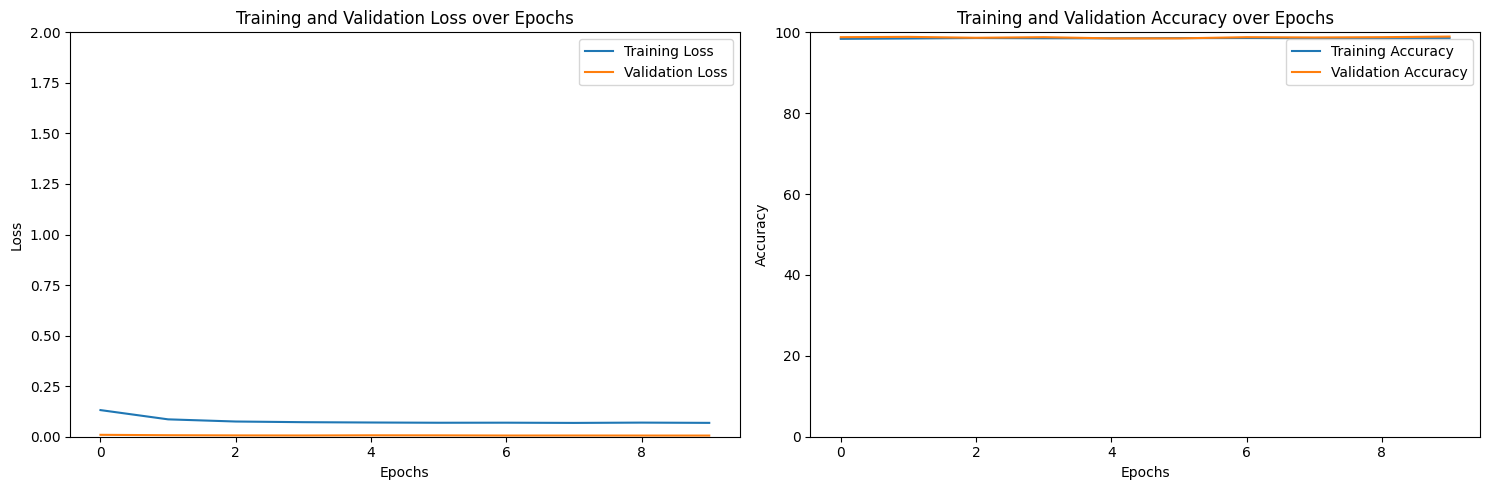

In [67]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()